In [1]:
import os
import dill as pickle
import pandas as pd
import pycmtensor as cmt
from pycmtensor import aet as aet
from pycmtensor.expressions import Beta, Weights
from pycmtensor.optimizers import Adam
from pycmtensor.results import Results
from pycmtensor.models import MNLogit
from reslogitlayer import ResLogitLayer

cmt.logger.set_level(cmt.logger.WARNING)
cmt.__version__

'0.6.1'

In [2]:
nb_path = os.path.abspath("")
model_average_sim = pd.read_csv("data/model_average_sim.csv")
model_average_sim.columns = model_average_sim.columns.str.upper()
# model_average_sp[["AV1", "AV2"]] = 1
db = cmt.Database("model_average_sim", model_average_sim, choiceVar="CHOICE")
globals().update(db.variables)

# additional steps to format database
db.data["CHOICE"] -= 1
time_columns = ["CAR_TIME", "AIR_TIME", "AIR_ACCESS", "RAIL_TIME", "RAIL_ACCESS", "HSR_TIME", "HSR_ACCESS"]
cost_columns = ["CAR_COST", "AIR_COST", "RAIL_COST", "HSR_COST"]
income_columns = ["INCOME"]
db.autoscale(variables=time_columns, default=60., verbose=True)
db.autoscale(variables=cost_columns, default=100., verbose=True)
db.autoscale(variables=income_columns, default=1000., verbose=True)

In [3]:
# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_access = Beta("b_access", 0.0, None, None, 0)
b_income_rail = Beta("b_income_rail", 0.0, None, None, 0)
b_income_hsr = Beta("b_income_hsr", 0.0, None, None, 0)
b_income_car = Beta("b_income_car", 0.0, None, None, 0)
b_female_car = Beta("b_female_car", 0.0, None, None, 0)
b_female_rail = Beta("b_female_rail", 0.0, None, None, 0)
b_female_air = Beta("b_female_air", 0.0, None, None, 0)

asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_air = Beta("asc_air", 0.0, None, None, 0)
asc_rail = Beta("asc_rail", 0.0, None, None, 0)
asc_hsr = Beta("asc_hsr", 0.0, None, None, 1)

# specify weight parameters
W1 = Weights("ResNet_01a", (4, 24), 0, True)
W2 = Weights("ResNet_01b", (24, 4), 0, True)

# W3 = Weights("ResNet_02a", (4, 16), 0, True)
# W4 = Weights("ResNet_02b", (16, 4), 0, True)

U_car = (
    b_cost * db["CAR_COST"]
    + b_time * db["CAR_TIME"]
    + b_income_car * db["INCOME"]
    + b_female_car * db["FEMALE"]
    + asc_car
)
U_air = (
    b_cost * db["AIR_COST"]
    + b_time * db["AIR_TIME"]
    + b_access * db["AIR_ACCESS"]
    + b_female_air * db["FEMALE"]
    + asc_air
)
U_rail = (
    b_cost * db["RAIL_COST"]
    + b_time * db["RAIL_TIME"]
    + b_access * db["RAIL_ACCESS"]
    + b_income_rail * db["INCOME"]
    + b_female_rail * db["FEMALE"]
    + asc_rail
)
U_hsr = (
    b_cost * db["HSR_COST"]
    + b_time * db["HSR_TIME"]
    + b_access * db["HSR_ACCESS"]
    + b_income_hsr * db["INCOME"]
    + asc_hsr
)

# Associate utility functions with the list
U = [U_car, U_air, U_rail, U_hsr]

U = ResLogitLayer(U, W1, W2).output
# U = ResLogitLayer(U, W3, W4).output

# Associate the availability conditions with the alternatives
# av = [db["AV1"], db["AV2"]]

# rll = ResLogitLayer(U, W1, W2)
model = MNLogit(U, av=None, database=db, name="mymodel")
model.add_params(locals())
model.config["patience"] = 36000
model.config["base_lr"] = 0.0005
model.config["max_lr"] = 0.05
model.config["cyclic_lr_step_size"] = 16
model.config["cyclic_lr_mode"] = "triangular2"

# train function
model = cmt.train(
    model,
    database=db,
    optimizer=Adam,
    batch_size=128,
    max_epoch=800,
    notebook=True,
)

with open("mymodel.pkl", "rb") as f:
    model = pickle.load(f)

result = Results(model, db, show_weights=True)


dataset: model_average_sim (n=4000)
batch size: 128
iterations per epoch: 31


Loglikelihood:  -5715.706  Score: 0.055

Epoch    0/24800:   0%|          | 0.00/24.8k [00:00<?, ?it/s]

[2022-03-09 14:59:22] WARNING: Maximum patience reached. Early stopping...


Optimization complete with accuracy of 62.450%. Max loglikelihood reached @ epoch 786.

Results for model: mymodel
Build time: 00:00:10
Estimation time: 00:01:06
Estimation rate: 12.198 epochs/s
Seed value: 999
Number of Beta parameters: 12
Tensor size: 192
Sample size: 4000
Excluded data: 0
Init loglikelihood: -5715.706
Final loglikelihood: -3697.598
Final loglikelihood reached at: epoch 786
Likelihood ratio test: 4036.216
Accuracy: 62.450%
Rho square: 0.353
Rho bar square: 0.317
Akaike Information Criterion: 7803.20
Bayesian Information Criterion: 9087.18
Final gradient norm: 0.041



In [4]:
result.print_beta_statistics()
result.print_correlation_matrix()
result.print_nn_weights()


Statistical Analysis:
                  Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_air       -0.915045  0.164181  -5.573391       0.0      0.01532  -59.729614          0.0
asc_car        0.483333  0.169853   2.845601  0.004433      0.00613   78.853075          0.0
asc_rail      -0.698094  0.257453  -2.711537  0.006697     0.092197   -7.571768          0.0
b_access      -0.375046  0.087606  -4.281076  0.000019      0.01618  -23.178942          0.0
b_cost        -2.532682  0.103871 -24.383024       0.0     0.015423 -164.209815          0.0
b_female_air   0.473254  0.088019   5.376724       0.0     0.014379   32.912231          0.0
b_female_car   0.112798  0.078745   1.432451  0.152015     0.018722    6.024926          0.0
b_female_rail  0.363635  0.143337    2.53693  0.011183     0.027333   13.303711          0.0
b_income_car  -0.287223  0.084797  -3.387187  0.000706     0.003407   -84.29716          0.0
b_income_hsr  -0.113183   0.08025  -1.410374  0.

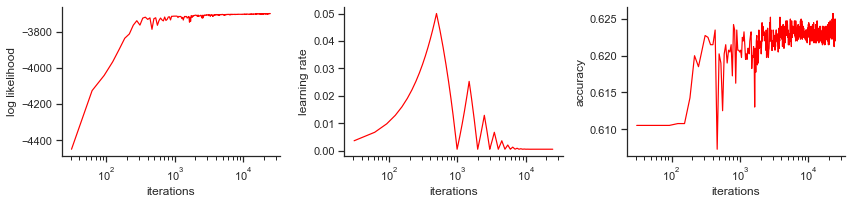

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()